In [1]:
%load_ext autoreload
%autoreload 2
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import torch.distributions as dist
import pickle
from tqdm import tqdm
import numpy as np
from models import RegressionMCDropoutModel
import matplotlib.pyplot as plt

In [2]:
with open('dataset2.pickle', 'rb') as f:
    data = pickle.loads(f.read())

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        assert self.X.shape[0]==self.y.shape[0]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]


X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y_regression'], test_size=0.20)

In [4]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [5]:
net = RegressionMCDropoutModel(X_train[0].shape[0], train_data_size=X_train.shape[0], lengthscale=1).cuda()

In [6]:
net.load_state_dict(torch.load('bayesian_regression_model'))
net.train(False)
points = []
sigmas = []
targets = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc, sigma = net.predict(inputs, num_samples=200)
    points.append(loc.detach().cpu().numpy())
    sigmas.append(sigma.detach().cpu().numpy())
    targets.append(target.detach().cpu().numpy())

points = np.concatenate(points)

In [7]:
net.load_state_dict(torch.load('bayesian_regression_model2'))
net.train(False)
points2 = []
sigmas = []
targets = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc, sigma = net.predict(inputs, num_samples=200)
    points2.append(loc.detach().cpu().numpy())
    sigmas.append(sigma.detach().cpu().numpy())
    targets.append(target.detach().cpu().numpy())

points2 = np.concatenate(points2)

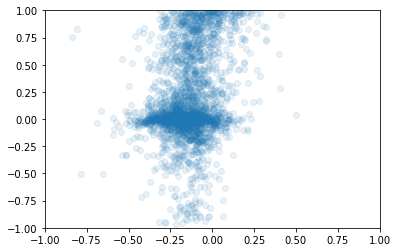

In [8]:
# oś ekonomiczna -1 lewica 1 prawica
plt.scatter(points[:, 0], points2[:, 1], alpha=0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1);

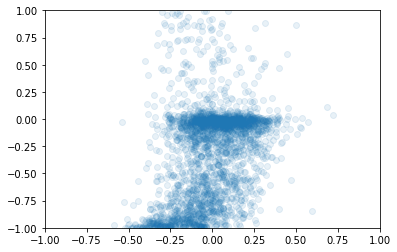

In [9]:
#oś światopoglądowa -1 liberalizm, 1 konserwatyzm
plt.scatter(points[:, 1], -points2[:, 0], alpha=0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1);

In [10]:
points2

array([[-0.45065865,  0.0419737 ],
       [-0.1093708 ,  0.95622206],
       [ 0.26751974,  0.08422737],
       ...,
       [-0.03416716,  0.96375155],
       [ 0.09815998,  0.7180896 ],
       [ 0.26942974,  0.10439564]], dtype=float32)